
### HUMAN ACTION DECTECTION IN AERIAL VIDEOS

Human action detection in videos (i.e., series of images) plays an important role in various real-life applications (e.g., visual surveillance and automated driver assistance, surveillance to image and video understanding). Aerial human action detection has several other applications like surveillance using Unmanned Aerial Vehicle (UAV), which provides a wider range of view, higher performance, search and rescue tasks, and human interaction understanding.

The objective of this project is to analyse and provide a novel approach
for human action detection using deep learning.
I try to establish a specific pattern in my proposed approach.

With rigorous literature survey and reviews of current approches towards the task of human action detection,
I have selected Okutama dataset for human action detection.

Challenges of HAR in aerial videos:

1) Variation of human sizes in videos.

2) Changing of altitude of the platform that camera is attached to.

3) Apperance of actor fades as resolution decreases.

In [1]:
import numpy as np
import pandas as pd

#Plotting 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 

# Importing sklearn libraries
from sklearn.metrics import confusion_matrix, accuracy_score

# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils

#model checkpoint
from keras.callbacks import ModelCheckpoint

#Feature extraction
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#Layers
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 

Using TensorFlow backend.


In [16]:
import os
train = [os.path.join("C:/Users/ANSH DESAI/Desktop/frames_rnn/train/",img) for img in os.listdir("C:/Users/ANSH DESAI/Desktop/frames_rnn/train")]
val = [os.path.join("C:/Users/ANSH DESAI/Desktop/frames_rnn/validation/",img) for img in os.listdir("C:/Users/ANSH DESAI/Desktop/frames_rnn/validation")]
test = [os.path.join("C:/Users/ANSH DESAI/Desktop/frames_rnn/test/",img) for img in os.listdir("C:/Users/ANSH DESAI/Desktop/frames_rnn/test/")]

In [17]:
len(train),len(val),len(test)

(6733, 1155, 1101)

In [18]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 9
 
# Convert class labels in one hot encoded vector
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)
train_y[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
len(train_y),len(val_y),len(test_y)

(6733, 1155, 1101)

Training data available in 9 classes
[705, 755, 734, 770, 725, 685, 793, 786, 780]


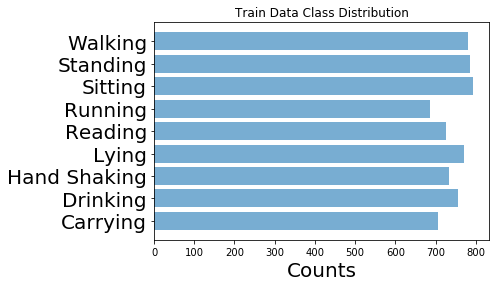

In [20]:
print("Training data available in 9 classes")
print([train_y.count(i) for i in range(0,9)])
 
action_classes = ('Carrying','Drinking','Hand Shaking','Lying','Reading','Running','Sitting','Standing','Walking')
 
y_pos = np.arange(len(action_classes))
counts = [train_y.count(i) for i in range(0,9)]
 
plt.barh(y_pos, counts, align='center', alpha=0.6)
plt.yticks(y_pos, action_classes,fontsize=20)
plt.xlabel('Counts',fontsize=20)
plt.title('Train Data Class Distribution')
plt.show()

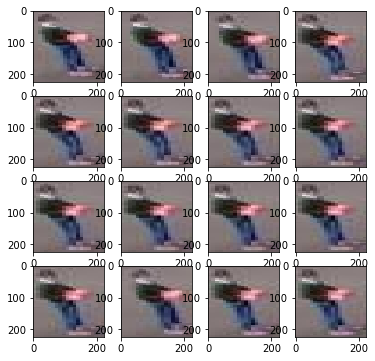

In [21]:
def show_imgs(X):
    plt.figure(figsize=(6, 6))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    plt.show()
show_imgs(train)

In [5]:
model = VGG16(weights="imagenet", include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

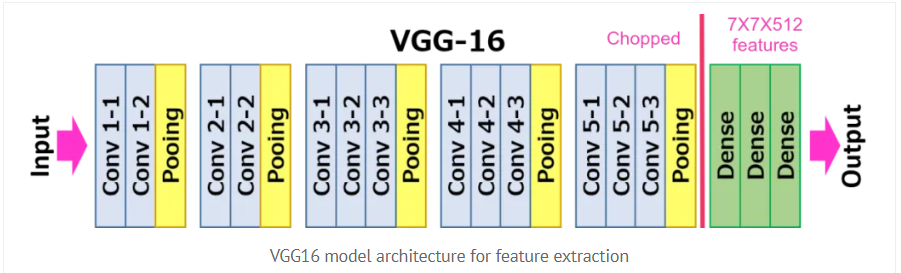

In [10]:
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

In [15]:
train_x, train_features, train_features_flatten = create_features(train, model)
#val_x, val_features, val_features_flatten = create_features(val, model)
#test_x, test_features, test_features_flatten = create_features(test, model)
 
print(train_x.shape, train_features.shape, train_features_flatten.shape)
#print(val_x.shape, val_features.shape, val_features_flatten.shape)
#print(test_x.shape, test_features.shape, test_features_flatten.shape)

(6733, 224, 224, 3) (6733, 7, 7, 512) (6733, 25088)


In [11]:
val_x, val_features, val_features_flatten = create_features(val, model)

In [12]:
print(val_x.shape, val_features.shape, val_features_flatten.shape)

(1155, 224, 224, 3) (1155, 7, 7, 512) (1155, 25088)


In [13]:
test_x, test_features, test_features_flatten = create_features(test, model)
print(test_x.shape, test_features.shape, test_features_flatten.shape)

(1101, 224, 224, 3) (1101, 7, 7, 512) (1101, 25088)


In [3]:
#np.save("D:/train_features.npy",train_features)
#np.save("D:/val_features.npy",val_features)
#np.save("D:/test_features.npy",test_features)
train_features = np.load("D:/train_features.npy")
val_features = np.load("D:/val_features.npy")
test_features = np.load("D:/test_features.npy")

In [6]:
train_features.shape

(6733, 49, 512)

In [9]:
val_features.shape

(1155, 49, 512)

In [6]:
def plot_history_2win(history):
    plt.subplot(211)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='g', label='Train')
    plt.plot(history.history['val_accuracy'], color='b', label='Validation')
    #plt.plot(history.history['test_accuracy'], color='b', label='Test')
    
    plt.legend(loc='best')

    plt.subplot(212)
    plt.title('Loss')
    plt.plot(history.history['loss'], color='g', label='Train')
    plt.plot(history.history['val_loss'], color='b', label='Validation')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


def create_history_plot(history, model_name, metrics):
    plt.title('Accuracy and Loss (' + model_name + ')')
    if metrics is None:
        metrics = {'accuracy', 'loss'}
    if 'accuracy' in metrics:
        plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
    if 'loss' in metrics:
        plt.plot(history.history['loss'], color='r', label='Train Loss')
        plt.plot(history.history['val_loss'], color='m', label='Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout()


def plot_history(history, model_name):
    create_history_plot(history, model_name)
    plt.show()


def plot_and_save_history(history, model_name, file_path, metrics):
    #if metrics is None:
        #metrics = {'acc', 'loss'}
    create_history_plot(history, model_name, metrics)
    plt.savefig(file_path)


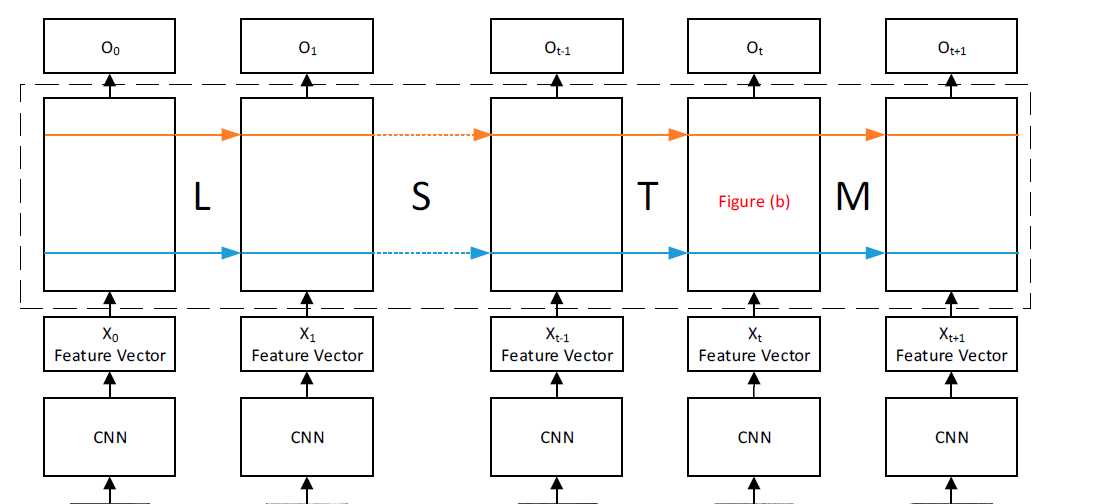

In [44]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Dropout
BATCH_SIZE = 64
NUM_EPOCHS = 10
VERBOSE = 1
HIDDEN_UNITS = 512
nb_classes = 9
def create_model():
        model1 = Sequential()

        model1.add(
            LSTM(units=HIDDEN_UNITS, input_shape=(49,512), return_sequences=False, dropout=0.5))
        model1.add(Dense(512, activation='relu'))
        model1.add(Dropout(0.5))
        model1.add(Dense(nb_classes))
        model1.add(Activation('softmax'))

        model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        return model1
model1 = create_model()
print("LSTM Model created")

LSTM Model created


In [149]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 4617      
_________________________________________________________________
activation_6 (Activation)    (None, 9)                 0         
Total params: 2,366,473
Trainable params: 2,366,473
Non-trainable params: 0
_________________________________________________________________


In [45]:
checkpointer = ModelCheckpoint(filepath='model1_scr.best.hdf5',
                               verbose=1,save_best_only=True)
checkpoint = ModelCheckpoint(filepath="D:/", save_best_only=True)
print("checkpoint created")
history = model1.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

checkpoint created
Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 63s 9ms/step - loss: 1.0757 - accuracy: 0.6143 - val_loss: 0.7953 - val_accuracy: 0.7576

Epoch 00001: val_loss improved from inf to 0.79526, saving model to model1_scr.best.hdf5
Epoch 2/10
6733/6733 [==============================] - 67s 10ms/step - loss: 0.4802 - accuracy: 0.8299 - val_loss: 0.7206 - val_accuracy: 0.8069

Epoch 00002: val_loss improved from 0.79526 to 0.72058, saving model to model1_scr.best.hdf5
Epoch 3/10
6733/6733 [==============================] - 64s 10ms/step - loss: 0.2863 - accuracy: 0.9002 - val_loss: 0.5154 - val_accuracy: 0.8649

Epoch 00003: val_loss improved from 0.72058 to 0.51539, saving model to model1_scr.best.hdf5
Epoch 4/10
6733/6733 [==============================] - 64s 9ms/step - loss: 0.2032 - accuracy: 0.9286 - val_loss: 0.9087 - val_accuracy: 0.7818

Epoch 00004: val_loss did not improve from 0.51539
Epoch 5/10
6733/6733 

In [13]:
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1]*test_features.shape[2],test_features.shape[3])

In [47]:
import sklearn
preds = np.argmax(model1.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,9))


Accuracy on Test Data:  0.7447774750227066

Number of correctly identified imgaes:  820 



array([[112,   9,   2,   0,  11,  13,   0,   0,   0],
       [  0, 122,   0,   0,   0,   0,   0,   0,   0],
       [  3,   3, 103,   0,   1,   4,   0,   1,  18],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 42,  25,   0,   0,  32,   8,  11,   0,  19],
       [  3,  15,   6,   4,   0, 124,   0,   0,   0],
       [  0,  27,   2,   0,   1,   0,  66,   0,   0],
       [  0,   1,  11,   0,   0,   0,   0,  77,   0],
       [  0,   0,  38,   0,   0,   0,   0,   3,  69]], dtype=int64)

In [48]:
print(sklearn.metrics.classification_report(test_y, preds, labels=None, target_names=action_classes, sample_weight=None, digits=4, output_dict=False))

              precision    recall  f1-score   support

    Carrying     0.7000    0.7619    0.7296       147
    Drinking     0.6040    1.0000    0.7531       122
Hand Shaking     0.6358    0.7744    0.6983       133
       Lying     0.9664    1.0000    0.9829       115
     Reading     0.7111    0.2336    0.3516       137
     Running     0.8322    0.8158    0.8239       152
     Sitting     0.8571    0.6875    0.7630        96
    Standing     0.9506    0.8652    0.9059        89
     Walking     0.6509    0.6273    0.6389       110

    accuracy                         0.7448      1101
   macro avg     0.7676    0.7517    0.7386      1101
weighted avg     0.7581    0.7448    0.7290      1101



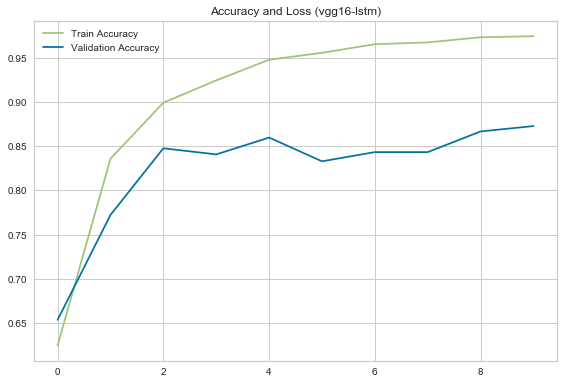

In [124]:
plot_and_save_history(history,'vgg16-lstm' , 'D:/' + 'lstm'+ '-history.png','accuracy')

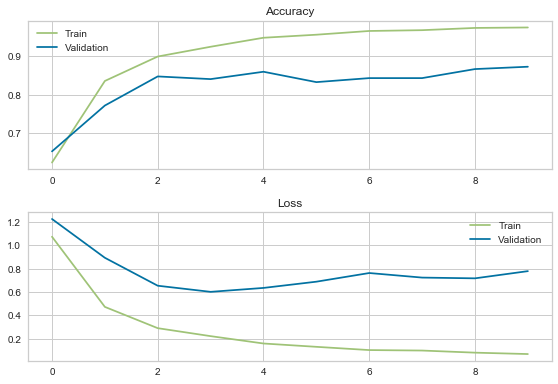

In [125]:
plot_history_2win(history)

In [69]:
def create_model_bilstm():
        model_bilstm = Sequential()
        model_bilstm.add(Bidirectional(LSTM(units=HIDDEN_UNITS, return_sequences=True),
                                input_shape=(train_features.shape[1],train_features.shape[2])))
        model_bilstm.add(Bidirectional(LSTM(10)))
        model_bilstm.add(Dense(512, activation='relu'))
        model_bilstm.add(Dropout(0.2))

        model_bilstm.add(Dense(nb_classes))

        model_bilstm.add(Activation('softmax'))

        model_bilstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        return model_bilstm

In [70]:
model_bilstm = create_model_bilstm()

In [50]:
model_bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 49, 1024)          4198400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20)                82800     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               10752     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 4,292,978
Trainable params: 4,292,978
Non-trainable params: 0
____________________________________________

In [71]:
checkpointer = ModelCheckpoint(filepath='scratchbilstm.best.hdf5',
                               verbose=1,save_best_only=True)
#checkpoint = ModelCheckpoint(filepath="D:/", save_best_only=True)
print("checkpoint created")
history = model_bilstm.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val),
          verbose=1, shuffle=True)

checkpoint created
Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 128s 19ms/step - loss: 0.5700 - accuracy: 0.8396 - val_loss: 0.4533 - val_accuracy: 0.8658
Epoch 2/10
6733/6733 [==============================] - 136s 20ms/step - loss: 0.0556 - accuracy: 0.9838 - val_loss: 0.6033 - val_accuracy: 0.8312
Epoch 3/10
6733/6733 [==============================] - 138s 20ms/step - loss: 0.0299 - accuracy: 0.9900 - val_loss: 0.5256 - val_accuracy: 0.8545
Epoch 4/10
6733/6733 [==============================] - 140s 21ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.4678 - val_accuracy: 0.8797
Epoch 5/10
6733/6733 [==============================] - 139s 21ms/step - loss: 0.0163 - accuracy: 0.9947 - val_loss: 0.5615 - val_accuracy: 0.8563
Epoch 6/10
6733/6733 [==============================] - 139s 21ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.6620 - val_accuracy: 0.8857
Epoch 7/10
6733/6733 [=============================

In [72]:
predsq = np.argmax(model_bilstm.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, predsq))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, predsq, normalize=False),"\n")
confusion_matrix(test_y, predsq, labels=range(0,9))


Accuracy on Test Data:  0.7311534968210718

Number of correctly identified imgaes:  805 



array([[114,   1,   0,   0,  26,   3,   0,   2,   1],
       [  0, 120,   1,   0,   0,   1,   0,   0,   0],
       [  0,   1,  95,   0,   0,  19,   0,   1,  17],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 48,  10,   0,   0,  55,   7,  10,   0,   7],
       [ 21,  16,   0,   3,   6, 102,   4,   0,   0],
       [  0,  21,  14,   0,   6,   0,  53,   2,   0],
       [  0,   0,   1,   0,   0,   0,   0,  88,   0],
       [  2,   0,  37,   0,   0,   6,   0,   2,  63]], dtype=int64)

In [76]:
print(sklearn.metrics.classification_report(test_y, predsq, labels=None, target_names=action_classes, sample_weight=None, digits=4, output_dict=False))

              precision    recall  f1-score   support

    Carrying     0.6162    0.7755    0.6867       147
    Drinking     0.7101    0.9836    0.8247       122
Hand Shaking     0.6419    0.7143    0.6762       133
       Lying     0.9746    1.0000    0.9871       115
     Reading     0.5914    0.4015    0.4783       137
     Running     0.7391    0.6711    0.7034       152
     Sitting     0.7910    0.5521    0.6503        96
    Standing     0.9263    0.9888    0.9565        89
     Walking     0.7159    0.5727    0.6364       110

    accuracy                         0.7312      1101
   macro avg     0.7452    0.7399    0.7333      1101
weighted avg     0.7313    0.7312    0.7221      1101



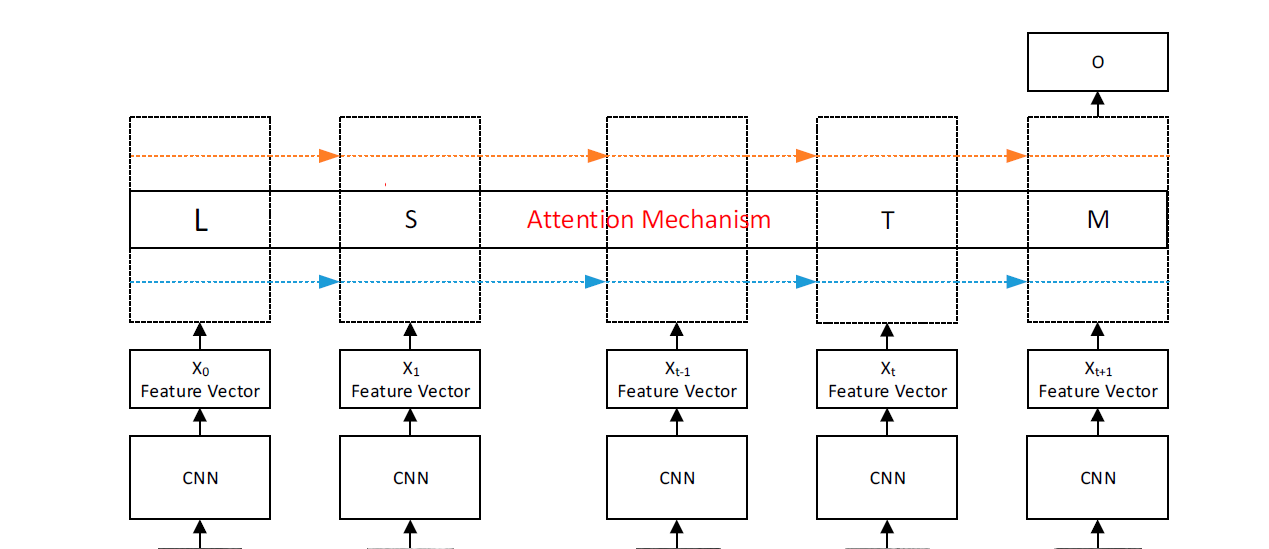

In [11]:
import keras
from keras import Input
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from keras import Model
from keras.layers import Dense, Activation, Dropout, Bidirectional,RepeatVector,Permute
BATCH_SIZE = 64
NUM_EPOCHS = 20
VERBOSE = 1
HIDDEN_UNITS = 512
#num_input_tokens = 7
nb_classes = 9
#from keras_self_attention import SeqSelfAttention
i = Input(shape=(49, 512))
x = LSTM(512, return_sequences=True)(i)
x = attention_3d_block(x)
x = Dropout(0.2)(x)
x = Dense(9, activation='softmax')(x)

modela = Model(inputs=[i], outputs=[x])
modela.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(modela.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49, 512)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 49, 512)      2099200     input_1[0][0]                    
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 49, 512)      262144      lstm_1[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 512)          0           lstm_1[0][0]                     
____________________________________________________________________________________________

In [22]:
history_a = modela.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val),
          verbose=1,shuffle=True)

Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 66s 10ms/step - loss: 0.3125 - val_loss: 0.6786
Epoch 2/10
6733/6733 [==============================] - 68s 10ms/step - loss: 0.0366 - val_loss: 0.5731
Epoch 3/10
6733/6733 [==============================] - 69s 10ms/step - loss: 0.0228 - val_loss: 0.6128
Epoch 4/10
6733/6733 [==============================] - 68s 10ms/step - loss: 0.0129 - val_loss: 0.6683
Epoch 5/10
6733/6733 [==============================] - 69s 10ms/step - loss: 0.0085 - val_loss: 0.6085
Epoch 6/10
6733/6733 [==============================] - 71s 11ms/step - loss: 0.0097 - val_loss: 0.7914
Epoch 7/10
6733/6733 [==============================] - 73s 11ms/step - loss: 0.0033 - val_loss: 1.1929
Epoch 8/10
6733/6733 [==============================] - 70s 10ms/step - loss: 0.0018 - val_loss: 0.7497
Epoch 9/10
6733/6733 [==============================] - 76s 11ms/step - loss: 0.0124 - val_loss: 0.8840
Epoch 10/10
6733

In [95]:
pred_att = np.argmax(modela.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, pred_att))
#print("\nNumber of correctly identified imgaes: ",
     # accuracy_score(test_y, pred_att, normalize=False),"\n")
#confusion_matrix(test_y, pred_att, labels=range(0,9))


Accuracy on Test Data:  0.8019981834695731


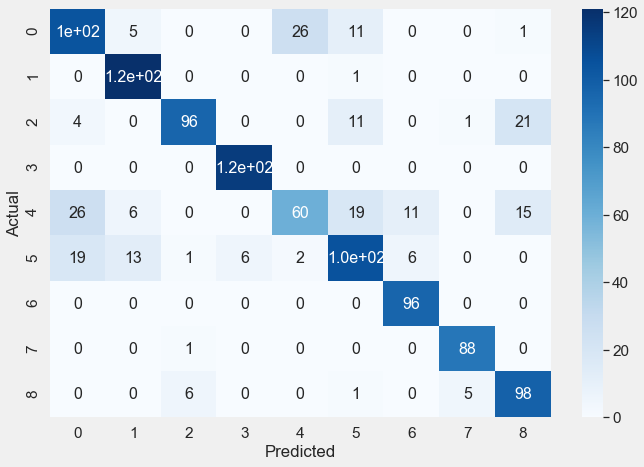

In [43]:
data = confusion_matrix(test_y,pred_att)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(pred_att))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [97]:
import sklearn
print(sklearn.metrics.classification_report(test_y, pred_att, labels=None, target_names=action_classes, sample_weight=None, digits=4, output_dict=False))

              precision    recall  f1-score   support

    Carrying     0.7970    0.7211    0.7571       147
    Drinking     0.9385    1.0000    0.9683       122
Hand Shaking     0.7705    0.7068    0.7373       133
       Lying     0.9127    1.0000    0.9544       115
     Reading     0.6325    0.7664    0.6931       137
     Running     0.7122    0.6513    0.6804       152
     Sitting     0.8851    0.8021    0.8415        96
    Standing     0.9605    0.8202    0.8848        89
     Walking     0.7541    0.8364    0.7931       110

    accuracy                         0.8020      1101
   macro avg     0.8181    0.8116    0.8122      1101
weighted avg     0.8060    0.8020    0.8014      1101



CONCLUSION:

Through this three approaches , I establish a pattern which is:

    Accuracy is higher for model with LSTM + attention than LSTM and BI-LSTM models.

    Focusing on specific regions and sequential(time) models prove to be better for classification for sequential data.
    

REFRENCES AND CITATIONS:

https://www.mdpi.com/507920

Liu, Y.; Xu, K.; Xu, J. Periodic Surface Defect Detection in Steel Plates Based on Deep Learning.

Human Action Recognition using CNN and LSTM-RNN with Attention Model
Pothanaicker, Kuppusamy. (2019). Human Action Recognition using CNN and LSTM-RNN with Attention Model. 8. 1639-1643. 

Recurrently exploring class-wise attention in a hybrid convolutional and
bidirectional LSTM network for multi-label aerial image classification
https://doi.org/10.1016/j.isprsjprs.2019.01.015

FUTURE ENHANCEMENT:

    1) Spatio-temporal graph attention mechanism.
    
    2) Fine tuning of these models with (extended resources).
    
    3) Transformer model.

In [41]:
pred_att

array([0, 0, 0, ..., 8, 8, 8], dtype=int64)

In [54]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [12]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history_bia = modela1.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val),
          verbose=1,shuffle=True)

Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 189s 28ms/step - loss: 0.2676 - accuracy: 0.9115 - val_loss: 0.4200 - val_accuracy: 0.8814
Epoch 2/10
6733/6733 [==============================] - 185s 28ms/step - loss: 0.0321 - accuracy: 0.9914 - val_loss: 0.5039 - val_accuracy: 0.8277
Epoch 3/10
6733/6733 [==============================] - 188s 28ms/step - loss: 0.0176 - accuracy: 0.9957 - val_loss: 0.4891 - val_accuracy: 0.8710
Epoch 4/10
6733/6733 [==============================] - 187s 28ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.3933 - val_accuracy: 0.8831
Epoch 5/10
6733/6733 [==============================] - 189s 28ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 0.5327 - val_accuracy: 0.8511
Epoch 6/10
6733/6733 [==============================] - 186s 28ms/step - loss: 0.0120 - accuracy: 0.9972 - val_loss: 0.5394 - val_accuracy: 0.8303
Epoch 7/10
6733/6733 [==============================] - 186s 28ms/step

In [16]:
pred_att = np.argmax(modela1.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, pred_att))
#print("\nNumber of correctly identified imgaes: ",
     # accuracy_score(test_y, pred_att, normalize=False),"\n")
#confusion_matrix(test_y, pred_att, labels=range(0,9))


Accuracy on Test Data:  0.8074477747502271


In [17]:
import sklearn
print(sklearn.metrics.classification_report(test_y, pred_att, labels=None, target_names=action_classes, sample_weight=None, digits=4, output_dict=False))

              precision    recall  f1-score   support

    Carrying     0.7931    0.7823    0.7877       147
    Drinking     0.6576    0.9918    0.7908       122
Hand Shaking     0.9000    0.7444    0.8148       133
       Lying     0.9426    1.0000    0.9705       115
     Reading     0.7132    0.7080    0.7106       137
     Running     0.7483    0.7434    0.7459       152
     Sitting     0.9000    0.4688    0.6164        96
    Standing     0.9412    0.8989    0.9195        89
     Walking     0.8814    0.9455    0.9123       110

    accuracy                         0.8074      1101
   macro avg     0.8308    0.8092    0.8076      1101
weighted avg     0.8206    0.8074    0.8032      1101



In [17]:
pred_att = np.argmax(modela.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, pred_att))
#print("\nNumber of correctly identified imgaes: ",
     # accuracy_score(test_y, pred_att, normalize=False),"\n")
confusion_matrix(test_y, pred_att, labels=range(0,9))


Accuracy on Test Data:  0.8228882833787466


array([[114,   4,   0,   0,  26,   2,   0,   0,   1],
       [  0, 122,   0,   0,   0,   0,   0,   0,   0],
       [  2,   6,  95,   0,   5,  23,   0,   0,   2],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 17,   7,   0,   0,  89,   3,  10,   0,  11],
       [  5,  26,   9,  10,   5,  96,   1,   0,   0],
       [  0,   8,   1,   0,   4,   0,  83,   0,   0],
       [  0,   0,   4,   0,   0,   0,   0,  84,   1],
       [  0,   0,   1,   0,   0,   1,   0,   0, 108]], dtype=int64)

In [23]:
model_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    #features_flatten = features.reshape((features.shape[0], 7 * 7 * 2048))
    return x, features

In [25]:
train_x_res, train_features_res = create_features(train, model_res)
#val_x, val_features, val_features_flatten = create_features(val, model)
#test_x, test_features, test_features_flatten = create_features(test, model)
 

#print(val_x.shape, val_features.shape, val_features_flatten.shape)
#print(test_x.shape, test_features.shape, test_features_flatten.shape)

In [26]:
print(train_x_res.shape, train_features_res.shape)

(6733, 224, 224, 3) (6733, 7, 7, 2048)


In [37]:
test_x_res, test_features_res = create_features(test, model_res)

In [40]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Dropout
BATCH_SIZE = 64
NUM_EPOCHS = 10
VERBOSE = 1
HIDDEN_UNITS = 512
nb_classes = 9
def create_model():
        model1 = Sequential()

        model1.add(
            LSTM(units=HIDDEN_UNITS, input_shape=(49,2048), return_sequences=False, dropout=0.5))
        model1.add(Dense(512, activation='relu'))
        model1.add(Dropout(0.5))
        model1.add(Dense(nb_classes))
        model1.add(Activation('softmax'))

        model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        return model1
model_r = create_model()
print("LSTM Model created")

LSTM Model created


In [55]:
model_r.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 512)               5244928   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 4617      
_________________________________________________________________
activation_3 (Activation)    (None, 9)                 0         
Total params: 5,512,201
Trainable params: 5,512,201
Non-trainable params: 0
_________________________________________________________________


In [41]:
checkpointer_res = ModelCheckpoint(filepath='model1_scr_r.best.hdf5',
                               verbose=1,save_best_only=True)
checkpoint_res = ModelCheckpoint(filepath="D:/", save_best_only=True)
print("checkpoint created")
history_res_lstm = model_r.fit(train_features_res, y_train, batch_size=64, epochs=10,
          validation_data=(val_features_res, y_val), callbacks=[checkpointer_res],
          verbose=1, shuffle=True)

checkpoint created
Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 30s 4ms/step - loss: 0.6028 - accuracy: 0.7919 - val_loss: 0.4957 - val_accuracy: 0.8502

Epoch 00001: val_loss improved from inf to 0.49566, saving model to model1_scr_r.best.hdf5
Epoch 2/10
6733/6733 [==============================] - 30s 4ms/step - loss: 0.1329 - accuracy: 0.9557 - val_loss: 0.5001 - val_accuracy: 0.8658

Epoch 00002: val_loss did not improve from 0.49566
Epoch 3/10
6733/6733 [==============================] - 30s 5ms/step - loss: 0.0638 - accuracy: 0.9805 - val_loss: 0.6256 - val_accuracy: 0.8857

Epoch 00003: val_loss did not improve from 0.49566
Epoch 4/10
6733/6733 [==============================] - 31s 5ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.4285 - val_accuracy: 0.9152

Epoch 00004: val_loss improved from 0.49566 to 0.42845, saving model to model1_scr_r.best.hdf5
Epoch 5/10
6733/6733 [==============================] - 32s 5

In [38]:
test_features_res = test_features_res.reshape(test_features_res.shape[0],test_features_res.shape[1]*test_features_res.shape[2],test_features_res.shape[3])

In [53]:
import sklearn
preds = np.argmax(model_r.predict(test_features_res), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,9))


Accuracy on Test Data:  0.8510445049954587

Number of correctly identified imgaes:  937 



array([[112,   0,   0,   0,  31,   4,   0,   0,   0],
       [  0, 121,   0,   0,   0,   1,   0,   0,   0],
       [  0,   2, 109,   0,   0,  10,   0,   2,  10],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 31,   3,   0,   0,  91,   0,   8,   0,   4],
       [  6,  16,   0,   1,   2, 107,   0,  19,   1],
       [  0,   4,   0,   0,   4,   0,  88,   0,   0],
       [  0,   0,   2,   0,   0,   1,   0,  86,   0],
       [  0,   0,   1,   0,   0,   0,   0,   1, 108]], dtype=int64)

In [62]:
def create_model_bilstm():
        model_bilstm = Sequential()
        model_bilstm.add(Bidirectional(LSTM(units=HIDDEN_UNITS, return_sequences=True),
                                input_shape=(train_features.shape[1],train_features.shape[2])))
        model_bilstm.add(Bidirectional(LSTM(10)))
        model_bilstm.add(Dense(512, activation='relu'))
        model_bilstm.add(x)
        model_bilstm.add(Dropout(0.5))

        model_bilstm.add(Dense(nb_classes))

        model_bilstm.add(Activation('softmax'))

        model_bilstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        return model_bilstm
BATCH_SIZE = 64
NUM_EPOCHS = 10
VERBOSE = 1
HIDDEN_UNITS = 512
nb_classes = 9

i = Input(shape=(49, 2048))
x = Bidirectional(LSTM(units=HIDDEN_UNITS, return_sequences=True),input_shape=(train_features_res.shape[1],train_features_res.shape[2]))(i)
#x = Bidirectional(LSTM(10))(x)
x = attention_3d_block(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)

modela1_r = Model(inputs=[i], outputs=[x])
modela1_r.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(modela1_r.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 49, 2048)     0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 49, 1024)     10489856    input_9[0][0]                    
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 49, 1024)     1048576     bidirectional_5[0][0]            
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 1024)         0           bidirectional_5[0][0]            
____________________________________________________________________________________________

In [63]:
import keras
from keras import Input
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from keras import Model
from keras.layers import Dense, Activation, Dropout, Bidirectional,RepeatVector,Permute

In [64]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history_bia_r = modela1_r.fit(train_features_res, y_train, batch_size=64, epochs=10,
          validation_data=(val_features_res, y_val),
          verbose=1,shuffle=True)

Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 72s 11ms/step - loss: 0.3336 - accuracy: 0.8972 - val_loss: 0.5312 - val_accuracy: 0.8320
Epoch 2/10
6733/6733 [==============================] - 70s 10ms/step - loss: 0.0776 - accuracy: 0.9792 - val_loss: 0.4260 - val_accuracy: 0.8615
Epoch 3/10
6733/6733 [==============================] - 70s 10ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.3788 - val_accuracy: 0.8874
Epoch 4/10
6733/6733 [==============================] - 70s 10ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 0.4230 - val_accuracy: 0.8788
Epoch 5/10
6733/6733 [==============================] - 71s 11ms/step - loss: 0.0280 - accuracy: 0.9927 - val_loss: 0.5260 - val_accuracy: 0.8675
Epoch 6/10
6733/6733 [==============================] - 68s 10ms/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.5625 - val_accuracy: 0.8641
Epoch 7/10
6733/6733 [==============================] - 63s 9ms/step - loss:

In [65]:
pred_att = np.argmax(modela1_r.predict(test_features_res), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, pred_att))



Accuracy on Test Data:  0.782016348773842


In [17]:
at_l = np.array([[.72, 0.31], [0.18, 0.50]])

In [18]:
at_bl = np.array([[.73, 0.20], [0.12, 0.60]])

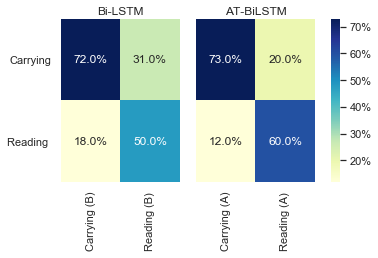

In [22]:
f,(ax1,ax4,axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[7,7,0.5]},figsize=(5,3))
ax1.get_shared_y_axes().join(ax4)
classs =['Carrying', 'Reading ']
sns.set(font_scale=1.0)
g1 = sns.heatmap(at_l,cmap="YlGnBu", ax=ax1, cbar=False,annot=True,fmt='.1%')

g1.set_xticklabels(['Carrying (B)','Reading (B)'],rotation='vertical')
g1.set_yticklabels(classs,rotation='horizontal')
g1.set_xlabel('Bi-LSTM')
g1.xaxis.set_label_position('top') 
g4 = sns.heatmap(at_bl,cmap="YlGnBu", ax=ax4,annot=True,cbar_ax=axcb,
cbar_kws={'format': FuncFormatter(fmt)},fmt='.1%')
g4.set_xticklabels(['Carrying (A)','Reading (A)'],rotation='vertical')
g4.set_xlabel('AT-BiLSTM')
g4.set_yticklabels('')
g4.xaxis.set_label_position('top') 
plt.show()